In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Building a song recommender

In [2]:
%matplotlib inline

import pandas
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import numpy as np
import time
#from sklearn.externals import joblib
import joblib
import Recommenders as Recommenders
import Evaluation as Evaluation

# Load music data

In [3]:
#Read userid-songid-listen_count triplets
#This step might take time to download data from external sources

#triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
triplets_file = 'songs_10000.txt'

#songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'
songs_metadata_file = 'song_data.csv'

In [4]:
song_df_1 = pandas.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

In [5]:
song_df_1.shape
song_df_1.columns
song_df_1.info()
song_df_1.head()

(2000000, 3)

Index(['user_id', 'song_id', 'listen_count'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   song_id       object
 2   listen_count  int64 
dtypes: int64(1), object(2)
memory usage: 45.8+ MB


,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [6]:
#Read song  metadata
song_df_2 =  pandas.read_csv(songs_metadata_file)

In [7]:
song_df_2.shape
song_df_2.columns
song_df_2.info()
song_df_2.head()

(1000000, 5)

Index(['song_id', 'title', 'release', 'artist_name', 'year'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999985 non-null   object
 2   release      999995 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB


,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [8]:
#Merge the two dataframes above to create input dataframe for recommender systems
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left") 

In [9]:
song_df.shape
song_df.columns
song_df.info()
song_df.head()

(2000000, 7)

Index(['user_id', 'song_id', 'listen_count', 'title', 'release', 'artist_name',
       'year'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   song_id       object
 2   listen_count  int64 
 3   title         object
 4   release       object
 5   artist_name   object
 6   year          int64 
dtypes: int64(2), object(5)
memory usage: 122.1+ MB


,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


# Explore data

Music data shows how many times a user listened to a song, as well as the details of the song.

In [10]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


## Length of the dataset

In [11]:
len(song_df)

2000000

## Create a subset of the dataset

In [12]:
song_df = song_df.head(10000)

#Merge song title and artist_name columns to make a merged column
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

In [13]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year,song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,The Cove - Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,Entre Dos Aguas - Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,Stronger - Kanye West
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005,Constellations - Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,Learn To Fly - Foo Fighters


## Showing the most popular songs in the dataset

In [14]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.45
4678,Undo - Björk,32,0.32
5105,You're The One - Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.28
3655,Secrets - OneRepublic,28,0.28
...,...,...,...
5139,high fives - Four Tet,1,0.01
5140,in white rooms - Booka Shade,1,0.01
5143,paranoid android - Christopher O'Riley,1,0.01
5149,¿Lo Ves? [Piano Y Voz] - Alejandro Sanz,1,0.01


## Count number of unique users in the dataset

In [15]:
users = song_df['user_id'].unique()

In [16]:
len(users)

365

## Quiz 1. Count the number of unique songs in the dataset

In [17]:
###Fill in the code here
songs = song_df['song'].unique()
len(songs)

5151

# Create a song recommender

In [18]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
#print(train_data.head(5))
train_data.head()

,user_id,song_id,listen_count,title,release,artist_name,year,song
7389,94d5bdc37683950e90c56c9b32721edb5d347600,SOXNZOW12AB017F756,2,Half Of My Heart,Battle Studies,John Mayer,0,Half Of My Heart - John Mayer
9275,1012ecfd277b96487ed8357d02fa8326b13696a5,SOXHYVQ12AB0187949,1,The Beautiful People,Antichrist Superstar (Ecopac Explicit),Marilyn Manson,0,The Beautiful People - Marilyn Manson
2995,15415fa2745b344bce958967c346f2a89f792f63,SOOSZAZ12A6D4FADF8,1,Sanctify Yourself,Glittering Prize 81/92,Simple Minds,1985,Sanctify Yourself - Simple Minds
5316,ffadf9297a99945c0513cd87939d91d8b602936b,SOWDJEJ12A8C1339FE,4,Heart Cooks Brain,Everything Is Nice: The Matador Records 10th A...,Modest Mouse,1997,Heart Cooks Brain - Modest Mouse
356,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAMPRJ12A8AE45F38,20,Rorol,Identification Parade,Octopus Project,2002,Rorol - Octopus Project


## Simple popularity-based recommender class (Can be used as a black box)

In [19]:
#Recommenders.popularity_recommender_py

### Create an instance of popularity based recommender class

In [20]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

### Use the popularity model to make some predictions

In [21]:
user_id = users[5]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Sehr kosmisch - Harmonia,37,1.0
4083,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Undo - Björk,27,2.0
931,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You're The One - Dwight Yoakam,24,4.0
3034,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Revelry - Kings Of Leon,21,5.0
3189,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Secrets - OneRepublic,21,6.0
4112,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Use Somebody - Kings Of Leon,21,7.0
1207,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Fireflies - Charttraxx Karaoke,20,8.0
1577,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hey_ Soul Sister - Train,19,9.0
1626,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


### Quiz 2: Use the popularity based model to make predictions for the following user id (Note the difference in recommendations from the first user id).

In [22]:
###Fill in the code here
user_id = users[8]
pm.recommend(user_id)


,user_id,song,score,Rank
3194,9bb911319fbc04f01755814cb5edb21df3d1a336,Sehr kosmisch - Harmonia,37,1.0
4083,9bb911319fbc04f01755814cb5edb21df3d1a336,Undo - Björk,27,2.0
931,9bb911319fbc04f01755814cb5edb21df3d1a336,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,9bb911319fbc04f01755814cb5edb21df3d1a336,You're The One - Dwight Yoakam,24,4.0
3034,9bb911319fbc04f01755814cb5edb21df3d1a336,Revelry - Kings Of Leon,21,5.0
3189,9bb911319fbc04f01755814cb5edb21df3d1a336,Secrets - OneRepublic,21,6.0
4112,9bb911319fbc04f01755814cb5edb21df3d1a336,Use Somebody - Kings Of Leon,21,7.0
1207,9bb911319fbc04f01755814cb5edb21df3d1a336,Fireflies - Charttraxx Karaoke,20,8.0
1577,9bb911319fbc04f01755814cb5edb21df3d1a336,Hey_ Soul Sister - Train,19,9.0
1626,9bb911319fbc04f01755814cb5edb21df3d1a336,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


## Build a song recommender with personalization

We now create an item similarity based collaborative filtering model that allows us to make personalized recommendations to each user. 

## Class for an item similarity based personalized recommender system (Can be used as a black box)

In [23]:
#Recommenders.item_similarity_recommender_py

### Create an instance of item similarity based recommender class

In [24]:
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

### Use the personalized model to make some song recommendations

In [25]:
#Print the songs for the user in training data
user_id = users[5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 4bd88bfb25263a75bbdd467e74018f4ae570e5df:
------------------------------------------------------------------------------------
Just Lose It - Eminem
Without Me - Eminem
16 Candles - The Crests
Speechless - Lady GaGa
Push It - Salt-N-Pepa
Ghosts 'n' Stuff (Original Instrumental Mix) - Deadmau5
Say My Name - Destiny's Child
My Dad's Gone Crazy - Eminem / Hailie Jade
The Real Slim Shady - Eminem
Somebody To Love - Justin Bieber
Forgive Me - Leona Lewis
Missing You - John Waite
Ya Nada Queda - Kudai
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 13
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2097


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman - Eminem / Dina Rae,0.088692,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird - Eminem,0.067663,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back - Eminem,0.065385,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile - Justin Bieber,0.064525,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Here Without You - 3 Doors Down,0.062293,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hellbound - J-Black & Masta Ace,0.055769,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,The Seed (2.0) - The Roots / Cody Chestnutt,0.052564,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm The One Who Understands (Edit Version) - War,0.052564,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Falling - Iration,0.052564,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Armed And Ready (2009 Digital Remaster) - The ...,0.052564,10


### Quiz 3. Use the personalized model to make recommendations for the following user id. (Note the difference in recommendations from the first user id.)

In [26]:
user_id = users[7]
#Fill in the code here
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)


------------------------------------------------------------------------------------
Training data songs for the user userid: 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec:
------------------------------------------------------------------------------------
Swallowed In The Sea - Coldplay
Life In Technicolor ii - Coldplay
Life In Technicolor - Coldplay
The Scientist - Coldplay
Trouble - Coldplay
Strawberry Swing - Coldplay
Lost! - Coldplay
Clocks - Coldplay
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :3429


,user_id,song,score,rank
0,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,She Just Likes To Fight - Four Tet,0.281579,1
1,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Warning Sign - Coldplay,0.281579,2
2,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,We Never Change - Coldplay,0.281579,3
3,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Puppetmad - Puppetmastaz,0.281579,4
4,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,God Put A Smile Upon Your Face - Coldplay,0.281579,5
5,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Susie Q - Creedence Clearwater Revival,0.281579,6
6,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,The Joker - Fatboy Slim,0.281579,7
7,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Korg Rhythm Afro - Holy Fuck,0.281579,8
8,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,This Unfolds - Four Tet,0.281579,9
9,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,high fives - Four Tet,0.281579,10


### We can also apply the model to find similar songs to any song in the dataset

In [27]:
is_model.get_similar_items(['U Smile - Justin Bieber'])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :271


,user_id,song,score,rank
0,,Somebody To Love - Justin Bieber,0.428571,1
1,,Bad Company - Five Finger Death Punch,0.375000,2
2,,Love Me - Justin Bieber,0.333333,3
3,,One Time - Justin Bieber,0.333333,4
4,,Here Without You - 3 Doors Down,0.333333,5
5,,Stuck In The Moment - Justin Bieber,0.333333,6
6,,Teach Me How To Dougie - California Swag District,0.333333,7
7,,Paper Planes - M.I.A.,0.333333,8
8,,Already Gone - Kelly Clarkson,0.333333,9
9,,The Funeral (Album Version) - Band Of Horses,0.300000,10


### Quiz 4. Use the personalized recommender model to get similar songs for the following song.

In [28]:
song = 'Yellow - Coldplay'
###Fill in the code here
is_model.get_similar_items([song])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :969


,user_id,song,score,rank
0,,Fix You - Coldplay,0.375000,1
1,,Creep (Explicit) - Radiohead,0.291667,2
2,,Clocks - Coldplay,0.280000,3
3,,Seven Nation Army - The White Stripes,0.250000,4
4,,Paper Planes - M.I.A.,0.208333,5
5,,Halo - Beyoncé,0.200000,6
6,,The Funeral (Album Version) - Band Of Horses,0.181818,7
7,,In My Place - Coldplay,0.181818,8
8,,Kryptonite - 3 Doors Down,0.166667,9
9,,When You Were Young - The Killers,0.166667,10


# Quantitative comparison between the models

We now formally compare the popularity and the personalized models using precision-recall curves. 

## Class to calculate precision and recall (This can be used as a black box)

In [29]:
#Evaluation.precision_recall_calculator

## Use the above precision recall calculator class to calculate the evaluation measures

In [30]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:319
Length of user sample:15
Getting recommendations for user:c1fc436b58e28b3e3f1b43a4e955baa19d8a69ba
No. of unique songs for the user: 13
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :1440
Getting recommendations for user:0560337e6a33be7149c9568b5fde5788294fe101
No. of unique songs for the user: 5
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :352
Getting recommendations for user:9fba771d9731561eba47216f6fbfc0023d88641b
No. of unique songs for the user: 51
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :6293
Getting recommendations for user:f47116f998e030f2dab275b81fb2a04a9dc06c33
No. of unique songs for the user: 7
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2001
Getting recommendations for user:e5a70dc3270e08ee11ab1325297eccb3158ce383
No. of unique songs for the user: 14
no. of unique songs in the

## Code to plot precision recall curve

In [31]:
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()


Plotting precision recall curves.


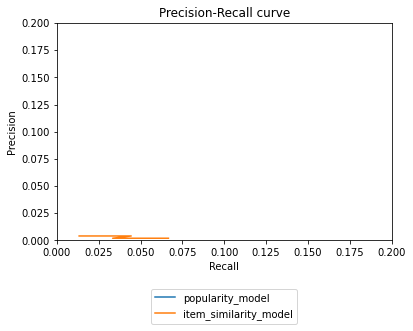

In [32]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")


### Generate Precision Recall curve using pickled results on a larger data subset(Python 3)

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


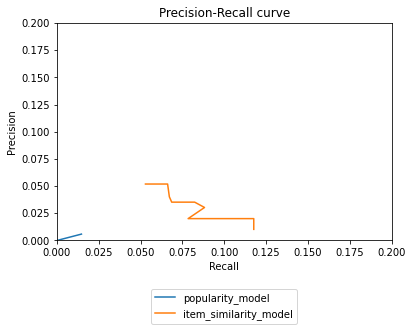

In [34]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

#Read the persisted files 
pm_avg_precision_list = joblib.load('pm_avg_precision_list_3.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_3.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_3.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_3.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

### Generate Precision Recall curve using pickled results on a larger data subset(Python 2.7)

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


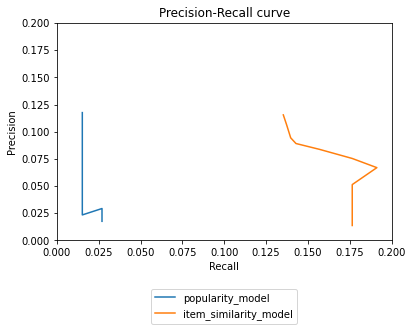

In [36]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

pm_avg_precision_list = joblib.load('pm_avg_precision_list_2.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_2.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_2.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_2.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

The curve shows that the personalized model provides much better performance over the popularity model. 